<h1>Model Training</h1>

In this notebook, we will use the Amazon SageMaker open source XGBoost container (https://github.com/aws/sagemaker-xgboost-container) to train a simple binary classification model, using the pre-processed data generated in the previous step by the processing job.
Using XGBoost as a framework provides more flexibility than using it as a built-in algorithm as it enables more advanced scenarios that allow pre-processing and post-processing scripts or any kind of custom logic to be incorporated into your training script.

Let's define the variables first.

In [1]:
# When using Amazon SageMaker Studio, please set this variable to True and execute the cell
use_sm_studio = False
if use_sm_studio:
    %cd /root/end-to-end-ml-sm/03_train_model/

In [2]:
import boto3
import sagemaker

role = sagemaker.get_execution_role()
region = boto3.Session().region_name
sagemaker_session = sagemaker.Session()
bucket_name = sagemaker_session.default_bucket()
prefix = 'endtoendmlsm'

print(region)
print(role)
print(bucket_name)

us-east-1
arn:aws:iam::208480242416:role/service-role/AmazonSageMaker-ExecutionRole-endtoendml
sagemaker-us-east-1-208480242416


## Training

The training code is implemented in the `source_dir/training.py` file.

The script parses arguments that are passed when the XGBoost Docker container code invokes the script for execution. These arguments represent the hyperparameters that you specify when strarting the training job plus the location of training and validation data. Then, we load training and validation data and execute XGBoost training with the provided parameters.

<strong>Note</strong>: this behavior, named Script Mode execution, is enabled by a library that is installed in the XGBoost container (sagemaker-containers, https://github.com/aws/sagemaker-containers) and facilitates the development of SageMaker-compatible Docker containers.


# Debugging
## LossNotDecreasing

Once we are confident our training script is working as expected (first execute the notebook without debugging enabled) and there are no major errors preventing its execution, we can enable debugging.

During training, we will save the state of the tensors using Amazon SageMaker debugging features, and then analyze debugging outputs with jobs that are run while the training job is executed. For XGBoost, Amazon SageMaker debugging supports saving evaluation metrics, lebels and predictions, feature importances, and SHAP values.

First, we need to modify our training script to enable Amazon SageMaker debugging. Note that this is required for the XGBoost framework, whilst for MXNet and Tensorflow debugging works also with no code changes.

We created a Hook object which we pass as a callback function when creating a Booster. The Hook object is created by loading a JSON configuration that is available in a specific path in the Docker container (opt/ml/input/config/debughookconfig.json); this file is generated by Amazon SageMaker from the CreateTrainingJob() API call configuration. Note that Amazon SageMaker debugging is highly configurable, you can choose exactly what to save.

Let's look at the modified script:


In [3]:
!pygmentize source_dir/training_debug.py

import argparse
import json
import os
import random
import pandas as pd
import glob
import pickle as pkl

import xgboost

from smdebug import SaveConfig
from smdebug.xgboost import Hook

def parse_args():

    parser = argparse.ArgumentParser()

    parser.add_argument("--max_depth", type=int, default=5)
    parser.add_argument("--eta", type=float, default=0.05)
    parser.add_argument("--gamma", type=int, default=4)
    parser.add_argument("--min_child_weight", type=int, default=6)
    parser.add_argument("--silent", type=int, default=0)
    parser.add_argument("--objective", type=str, default="reg:logistic")
    parser.add_argument("--num_round", type=int, default=10)
    
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--validation', type=str, default=os.environ.get('SM_CHANNEL_VALIDATION'))

    args = parser.parse_args()

    return args

def main():

    args = parse_args()
    train_files_path, validation_files_pa



The modified script allows to capture tensors and save to Amazon S3, but doing this will not cause any debug analysis to run. In order to analyze debug outputs we need to configure the XGBoost estimator to define a collection of rules that will be run while the training job is executed.

We are enabling a built-in (1P) debug rule named LossNotDecreasing which checks if the loss is not decreasing across step. In this scenario, we have chosen to run this rule at every step on the validation-rmse metric values: this means that the new rmse values must always go down at each step.

When the estimator fit() method is called, Amazon SageMaker will start two jobs: a Training Job, where we also capture and save tensors, and a debug Processing Job (powered by Amazon SageMaker Processing Jobs), which will run in parallel and analyze tensor data to check if the rule conditions are met.

Note that we are passing the Wait=False parameter to the fit() method to avoid waiting for the training job to complete and just fire and forget the API call.


Once we have our script ready, we can leverage on the XGBoost estimator of the Amazon SageMaker Python SDK to start training.

In [4]:
from sagemaker.xgboost import XGBoost
from sagemaker.debugger import Rule, rule_configs, DebuggerHookConfig, CollectionConfig

hyperparameters = {
    "max_depth": "3",
    "eta": "0.1",
    "gamma": "6",
    "min_child_weight": "6",
    "silent": "0",
    "objective": "reg:logistic",
    "num_round": "20"
}

entry_point='training_debug.py'
source_dir='source_dir/'
output_path = 's3://{0}/{1}/output/'.format(bucket_name, prefix)
debugger_output_path = 's3://{0}/{1}/output/debug'.format(bucket_name, prefix) # Path where we save debug outputs
code_location = 's3://{0}/{1}/code'.format(bucket_name, prefix)

hook_config = DebuggerHookConfig(
    s3_output_path=debugger_output_path,
    hook_parameters={
        "save_interval": "1"
    },
    collection_configs=[
        CollectionConfig("hyperparameters"),
        CollectionConfig("metrics"),
        CollectionConfig("predictions"),
        CollectionConfig("labels"),
        CollectionConfig("feature_importance"),
        CollectionConfig("average_shap")
    ]
)

estimator = XGBoost(
    base_job_name="end-to-end-ml-sm-xgb",
    entry_point=entry_point,
    source_dir=source_dir,
    output_path=output_path,
    code_location=code_location,
    hyperparameters=hyperparameters,
    train_instance_type="ml.m5.xlarge", # Specify local as instance type to run local-mode training
    train_instance_count=1,
    framework_version="0.90-2",
    py_version="py3",
    role=role,
    # Initialize your hook.
    debugger_hook_config=hook_config,
    
    # Initialize your rules. These will read data for analyses from the path specified
    # for the hook
    rules=[Rule.sagemaker(rule_configs.loss_not_decreasing(),
                         rule_parameters={
                             # Rule does not use the default losses collection,
                             # but uses a regex to look for specific tensor values
                             "use_losses_collection": "False",
                             "tensor_regex": "validation-rmse",
                             "collection_names": "metrics",
                             # Num steps is used to specify when to evaluate this rule (every num_steps)
                             "num_steps" : "1"}
                         )]
)

In [5]:
experiment_name='end-to-end-ml-sagemaker'

# Experiment tracking configuration
experiment_config={
    "ExperimentName": experiment_name,
    "TrialName": 'sklearn-xgboost',
    "TrialComponentDisplayName": "xgboost-training",
}

train_config = sagemaker.session.s3_input('s3://{0}/{1}/data/preprocessed/train/'.format(
    bucket_name, prefix), content_type='text/csv')
val_config = sagemaker.session.s3_input('s3://{0}/{1}/data/preprocessed/val/'.format(
    bucket_name, prefix), content_type='text/csv')

estimator.fit({'train': train_config, 'validation': val_config },
              experiment_config=experiment_config, wait=False)

Once the training job has started, we can check its debug configuration and status:

In [33]:
import time
client = estimator.sagemaker_session.sagemaker_client

description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
print('Debug Hook configuration: ')
print(description['DebugHookConfig'])
print()
print('Debug rules configuration: ')
print(description['DebugRuleConfigurations'])
print()
print('Training job status')
print(description['TrainingJobStatus'])

Debug Hook configuration: 
{'S3OutputPath': 's3://sagemaker-us-east-1-208480242416/endtoendmlsm/output/debug', 'HookParameters': {'save_interval': '1'}, 'CollectionConfigurations': [{'CollectionName': 'predictions'}, {'CollectionName': 'metrics'}, {'CollectionName': 'hyperparameters'}, {'CollectionName': 'feature_importance'}, {'CollectionName': 'average_shap'}, {'CollectionName': 'labels'}, {'CollectionName': 'losses', 'CollectionParameters': {'save_interval': '500'}}]}

Debug rules configuration: 
[{'RuleConfigurationName': 'LossNotDecreasing', 'RuleEvaluatorImage': '503895931360.dkr.ecr.us-east-1.amazonaws.com/sagemaker-debugger-rules:latest', 'VolumeSizeInGB': 0, 'RuleParameters': {'collection_names': 'metrics', 'num_steps': '1', 'rule_to_invoke': 'LossNotDecreasing', 'tensor_regex': 'validation-merror', 'use_losses_collection': 'False'}}]

Training job status
Completed


We can also get all the logs for the training job being executed:

In [7]:
sagemaker_session.logs_for_job(estimator.latest_training_job.name)

2020-04-08 11:34:38 Starting - Launching requested ML instances.

At the same time, we can check the status of the rule execution job as follows. Note that this requires some time, so you might be interested in looking at the SageMaker Debugger documentation while this runs: https://github.com/awslabs/sagemaker-debugger.

In [8]:
import time

client = estimator.sagemaker_session.sagemaker_client

iterate = True
while(iterate):
    description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
    eval_status = description['DebugRuleEvaluationStatuses'][0]
    print(eval_status)
    if eval_status['RuleEvaluationStatus'] != 'InProgress':
        iterate = False
    else:
        time.sleep(60)

{'RuleConfigurationName': 'LossNotDecreasing', 'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:208480242416:processing-job/end-to-end-ml-sm-xgb-2020--lossnotdecreasing-b7b24210', 'RuleEvaluationStatus': 'InProgress', 'LastModifiedTime': datetime.datetime(2020, 4, 8, 11, 36, 24, 744000, tzinfo=tzlocal())}
{'RuleConfigurationName': 'LossNotDecreasing', 'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:208480242416:processing-job/end-to-end-ml-sm-xgb-2020--lossnotdecreasing-b7b24210', 'RuleEvaluationStatus': 'InProgress', 'LastModifiedTime': datetime.datetime(2020, 4, 8, 11, 37, 25, 744000, tzinfo=tzlocal())}
{'RuleConfigurationName': 'LossNotDecreasing', 'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:208480242416:processing-job/end-to-end-ml-sm-xgb-2020--lossnotdecreasing-b7b24210', 'RuleEvaluationStatus': 'InProgress', 'LastModifiedTime': datetime.datetime(2020, 4, 8, 11, 38, 26, 941000, tzinfo=tzlocal())}
{'RuleConfigurationName': 'LossNotDecreasing', 'RuleEvaluationJobAr

Let's review the configuration and logs of the rule execution job, executed by Amazon SageMaker Processing Jobs:

In [9]:
processing_job_arn = eval_status['RuleEvaluationJobArn']
processing_job_name = processing_job_arn[processing_job_arn.rfind('/') + 1 :]
print(processing_job_name)

client = estimator.sagemaker_session.sagemaker_client
descr = client.describe_processing_job(ProcessingJobName=processing_job_name)
descr

end-to-end-ml-sm-xgb-2020--lossnotdecreasing-b7b24210


{'ProcessingInputs': [{'InputName': 'Tensors',
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-208480242416/endtoendmlsm/output/debug/end-to-end-ml-sm-xgb-2020-04-08-11-34-36-607/debug-output',
    'LocalPath': '/opt/ml/processing/input/tensors',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}}],
 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'RuleOutput',
    'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-208480242416/endtoendmlsm/output/end-to-end-ml-sm-xgb-2020-04-08-11-34-36-607/rule-output',
     'LocalPath': '/opt/ml/processing/output/rule',
     'S3UploadMode': 'EndOfJob'}}]},
 'ProcessingJobName': 'end-to-end-ml-sm-xgb-2020--LossNotDecreasing-b7b24210',
 'ProcessingResources': {'ClusterConfig': {'InstanceCount': 1,
   'InstanceType': 'ml.t3.medium',
   'VolumeSizeInGB': 30}},
 'StoppingCondition': {'MaxRuntimeInSeconds': 86400},
 'AppSpecification': {'ImageUri': '503895931360.d

In [10]:
sagemaker_session.logs_for_processing_job(descr['ProcessingJobName'])

[2020-04-08 11:40:36.996 ip-10-0-173-230.ec2.internal:1 INFO local_trial.py:35] Loading trial base_trial at path /opt/ml/processing/input/tensors
No environment variable found with name "base_trial". Will use default param value if present
No environment variable found with name "diff_percent". Will use default param value if present
No environment variable found with name "increase_threshold_percent". Will use default param value if present
No environment variable found with name "mode". Will use default param value if present
No environment variable found with name "absolute_val". Will use default param value if present
[2020-04-08 11:40:37.062 ip-10-0-173-230.ec2.internal:1 INFO loss_decrease.py:89] LossNotDecreasing rule created with num_steps: 1, diff_percent: 0.1, increase_threshold_percent: 5.0, mode: GLOBAL, tensor_regex: validation-merror, collection_names: metrics absolute_val:True
[2020-04-08 11:40:37.062 ip-10-0-173-230.ec2.internal:1 INFO rule_invoker.py:15] Started execut


Analyzing Debug Outputs

In this section we will see how you can use the SDK to manually analyze debug outputs.

First thing is creating a trial, which is the construct that allows accessing to tensors for a single training run.


In [11]:
!pip install smdebug

    100% |████████████████████████████████| 163kB 17.4MB/s ta 0:00:01
    100% |████████████████████████████████| 20.2MB 2.5MB/s eta 0:00:01    62% |████████████████████            | 12.6MB 85.3MB/s eta 0:00:01
  Found existing installation: numpy 1.14.3
    Uninstalling numpy-1.14.3:
      Successfully uninstalled numpy-1.14.3
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
from smdebug.trials import create_trial

s3_output_path = description["DebugHookConfig"]["S3OutputPath"] + '/' + estimator.latest_training_job.name + '/debug-output/'
print(s3_output_path)
trial = create_trial(s3_output_path)

s3://sagemaker-us-east-1-208480242416/endtoendmlsm/output/debug/end-to-end-ml-sm-xgb-2020-04-08-11-34-36-607/debug-output/
[2020-04-08 11:42:38.488 ip-172-16-48-166:16988 INFO s3_trial.py:42] Loading trial  at path s3://sagemaker-us-east-1-208480242416/endtoendmlsm/output/debug/end-to-end-ml-sm-xgb-2020-04-08-11-34-36-607/debug-output/


Now we can print the list of all the tensors that were saved.

In [13]:
trial.tensor_names()

[2020-04-08 11:43:05.684 ip-172-16-48-166:16988 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-04-08 11:43:06.712 ip-172-16-48-166:16988 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f16',
 'average_shap/f17',
 'average_shap/f18',
 'average_shap/f19',
 'average_shap/f2',
 'average_shap/f20',
 'average_shap/f21',
 'average_shap/f22',
 'average_shap/f23',
 'average_shap/f24',
 'average_shap/f25',
 'average_shap/f26',
 'average_shap/f27',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f20',
 'feature_importance/cover/f21',
 'feature_importance/cover/f22',
 'feature_importance/cover/f23',
 'feature_importance/cover/f26',
 'feature_importance/gain/f20',
 'feature_importance/gain/f21',
 'feature_importance/gain/f22',
 'feature_importance/gain/f23',
 'feature_importance/gain/f26',
 'feature_importance/total_cover/f20',
 'feature_importance/total_cover/f21',
 'feature_importanc

Given a specific tensor, we can ask at which steps we have data for the tensor. In this case, we have data for all steps since the frequency was set to 1.

In [15]:
trial.tensor("validation-rmse").steps()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [16]:
trial.tensor("train-rmse").value(5)

array([0.33075])

In [28]:
trial.tensor("predictions").value(5)

array([0.269036  , 0.269036  , 0.269036  , ..., 0.30302474, 0.269036  ,
       0.30229217], dtype=float32)


## Performance metrics¶

We can also create a simple function that visualizes the training and validation errors as the training progresses. We expect each training errors to get smaller over time, as the system converges to a good solution. Now, remember that this is an interactive analysis - we are showing these tensors to give an idea of the data.


In [31]:


import matplotlib.pyplot as plt
import seaborn as sns
import re


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()
    #print(collection_name)
    tensors = trial.collection(collection_name).tensor_names
    #print(tensors)
    for tensor_name in sorted(tensors):
        #print(tensor_name)
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            #print(np.mean(np.abs(data)))
            #if np.mean(np.abs(data)) > 0.001 :
            ax.plot(steps, data, label=tensor_name)
            
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')
    
def plot_tensors(trial, tensors, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and tensor names, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()
    #print(tensors)
    #tensors = trial.collection(collection_name).tensor_names
    #print(tensors)
    for tensor_name in sorted(tensors):
        #print(tensor_name)
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            #if np.mean(np.abs(data)) > 0.05 :
            ax.plot(steps, data, label=tensor_name)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')




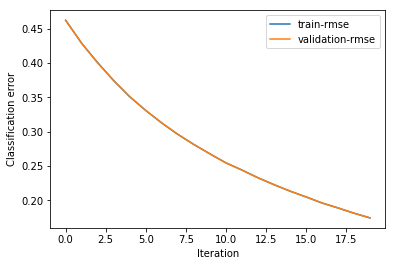

In [20]:
metrics_to_plot = ["train-rmse", "validation-rmse"]
for metric in metrics_to_plot:
    steps, data = get_data(trial, metric)
    plt.plot(steps, data, label=metric)
plt.xlabel('Iteration')
plt.ylabel('Classification error')
plt.legend()
plt.show()


Feature importance

We can also visualize the feature importances as determined by xgboost.get_fscore(). Note that feature importances with zero values are not included here (which means that those features were not used in any split conditions).

For more information on the metrics related to feature importance in XGBoost, please visit: https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

weight is the number of times a feature is used to split the data across all trees
gain represents fractional contribution of each feature to the model based on the total gain of this feature's splits. Higher percentage means a more important predictive feature
cover is a metric of the number of observation related to this feature
total_gain is the total gain across all splits the feature is used in
total_cover is the total coverage across all splits the feature is used in 

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
    
def plot_feature_importance(trial, collection_name, step, metric):
    feature_importance_tensors = trial.collection(collection_name).tensor_names

    feature_names = []
    feature_values = []
    
    plt.subplots(figsize=(18,7))
    
    for tensor_name in feature_importance_tensors:
        if tensor_name.find('/' + metric) >= 0:
            index = tensor_name.rfind('/')
            feature_name = tensor_name[index+1:]
            feature_names.append(feature_name)
            tensor = trial.tensor(tensor_name)
            value_at_step = tensor.value(step)[0]
            feature_values.append(value_at_step)

    pos = range(len(feature_values))
    plt.bar(pos, feature_values, color='g')
    plt.xlabel('Features', fontsize=16)
    plt.ylabel('Feature Importance ({0})'.format(metric), fontsize=16)
    plt.xticks(pos, feature_names)
    plt.show()

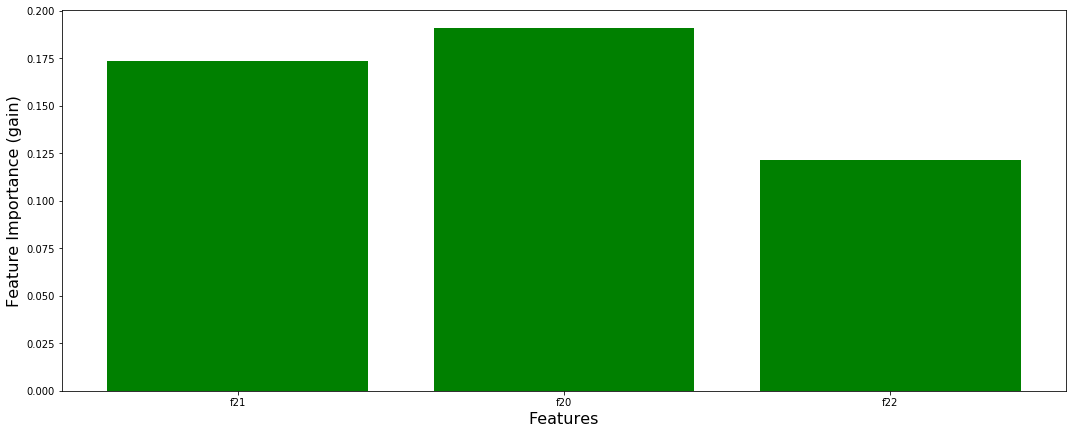

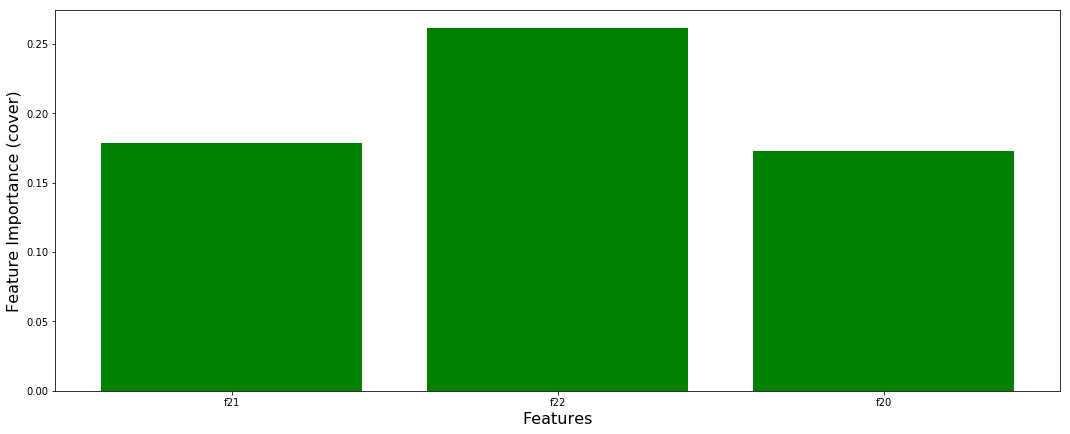

In [23]:

plot_feature_importance(trial, "feature_importance", 19, "gain")
plot_feature_importance(trial, "feature_importance", 19, "cover")



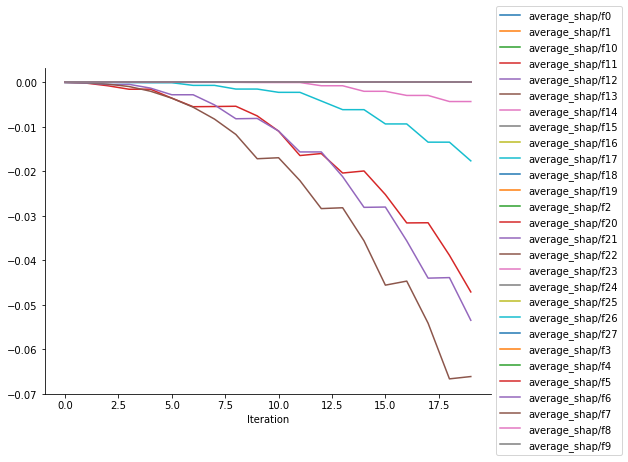

In [32]:
plot_collection(trial,"average_shap")


### Experiment analytics

You can visualize experiment analytics either from Amazon SageMaker Studio Experiments plug-in or using the SDK from a notebook, as follows:

In [ ]:
from sagemaker.analytics import ExperimentAnalytics

analytics = ExperimentAnalytics(experiment_name=experiment_name)
analytics.dataframe()

After the training is completed, the serialized model will be saved in the S3 `output_location` defined above.
You can now move to the next notebook in the **04_deploy_model** folder to see how to use that model for inference.